In [5]:
"""
1. Definicja Problemu
Celem projektu jest analiza i prognoza cen zamknięcia akcji spółki Apple (AAPL).
Hipoteza badawcza:
1. Akcje Apple wykazują silną sezonowość roczną (powiązaną z cyklem wydawniczym iPhone'a).
2. Modele oparte na sieciach neuronowych (LSTM) lepiej poradzą sobie z nieliniowością rynku niż klasyczna ARIMA.

2. Źródło danych
Dane pochodzą ze zbioru 'Apple Comprehensive Financial Dataset' (Kaggle).
Zawierają notowania giełdowe oraz wskaźniki techniczne i fundamentalne.
"""

"\n1. Definicja Problemu\nCelem projektu jest analiza i prognoza cen zamknięcia akcji spółki Apple (AAPL).\nHipoteza badawcza:\n1. Akcje Apple wykazują silną sezonowość roczną (powiązaną z cyklem wydawniczym iPhone'a).\n2. Modele oparte na sieciach neuronowych (LSTM) lepiej poradzą sobie z nieliniowością rynku niż klasyczna ARIMA.\n\n2. Źródło danych\nDane pochodzą ze zbioru 'Apple Comprehensive Financial Dataset' (Kaggle).\nZawierają notowania giełdowe oraz wskaźniki techniczne i fundamentalne.\n"

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Biblioteka do modelu Prophet
from prophet import Prophet

# Biblioteki do LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Ustawienia wykresy
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

In [11]:
# Wczytanie danych
df = pd.read_csv('aapl_master_enriched.csv', on_bad_lines='skip', engine='python')
print(df.head())
# Konwersja kolumny date na format datetime (ważne w szeregach czasowych)
df['date'] = pd.to_datetime(df['date'])

# Ustawienie daty jako indeksu dla ułatwienia filtrowania i rysowanie wykresów
df.set_index('date', inplace=True)

# Sortowanie indeksu
df.sort_index(inplace=True)

# Wybranie tylko ceny zamknięcia
data = df[['close']]

# Ograniczenie danych do 2005 roku
data = data[data.index >= '2005-01-01']

print(data.head())
print(data.tail())

         date      open      high       low     close     volume  dividends  \
0  1980-12-12  0.098389  0.098817  0.098389  0.098389  469033600        0.0   
1  1980-12-15  0.093684  0.093684  0.093256  0.093256  175884800        0.0   
2  1980-12-16  0.086839  0.086839  0.086412  0.086412  105728000        0.0   
3  1980-12-17  0.088550  0.088978  0.088550  0.088550   86441600        0.0   
4  1980-12-18  0.091118  0.091545  0.091118  0.091118   73449600        0.0   

   stock_splits  price_range  price_change  ...  revenue_services  \
0           0.0     0.000428      0.000000  ...               NaN   
1           0.0     0.000428     -0.000428  ...               NaN   
2           0.0     0.000428     -0.000428  ...               NaN   
3           0.0     0.000428      0.000000  ...               NaN   
4           0.0     0.000428      0.000000  ...               NaN   

   revenue_wearables_other  revenue_ipad  revenue_iphone  revenue_total  \
0                      NaN         

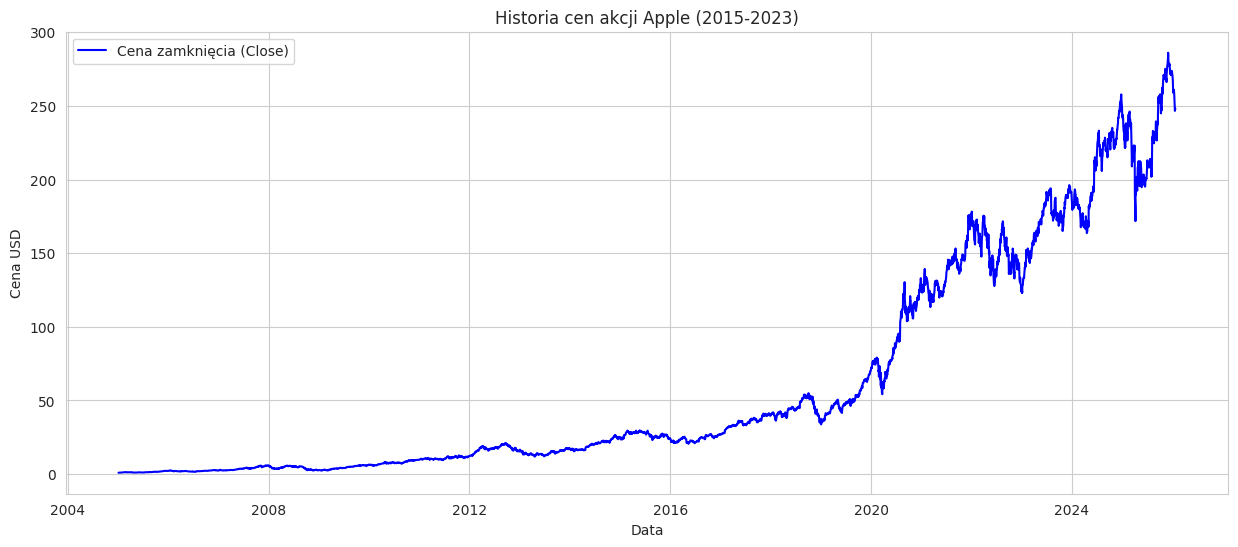

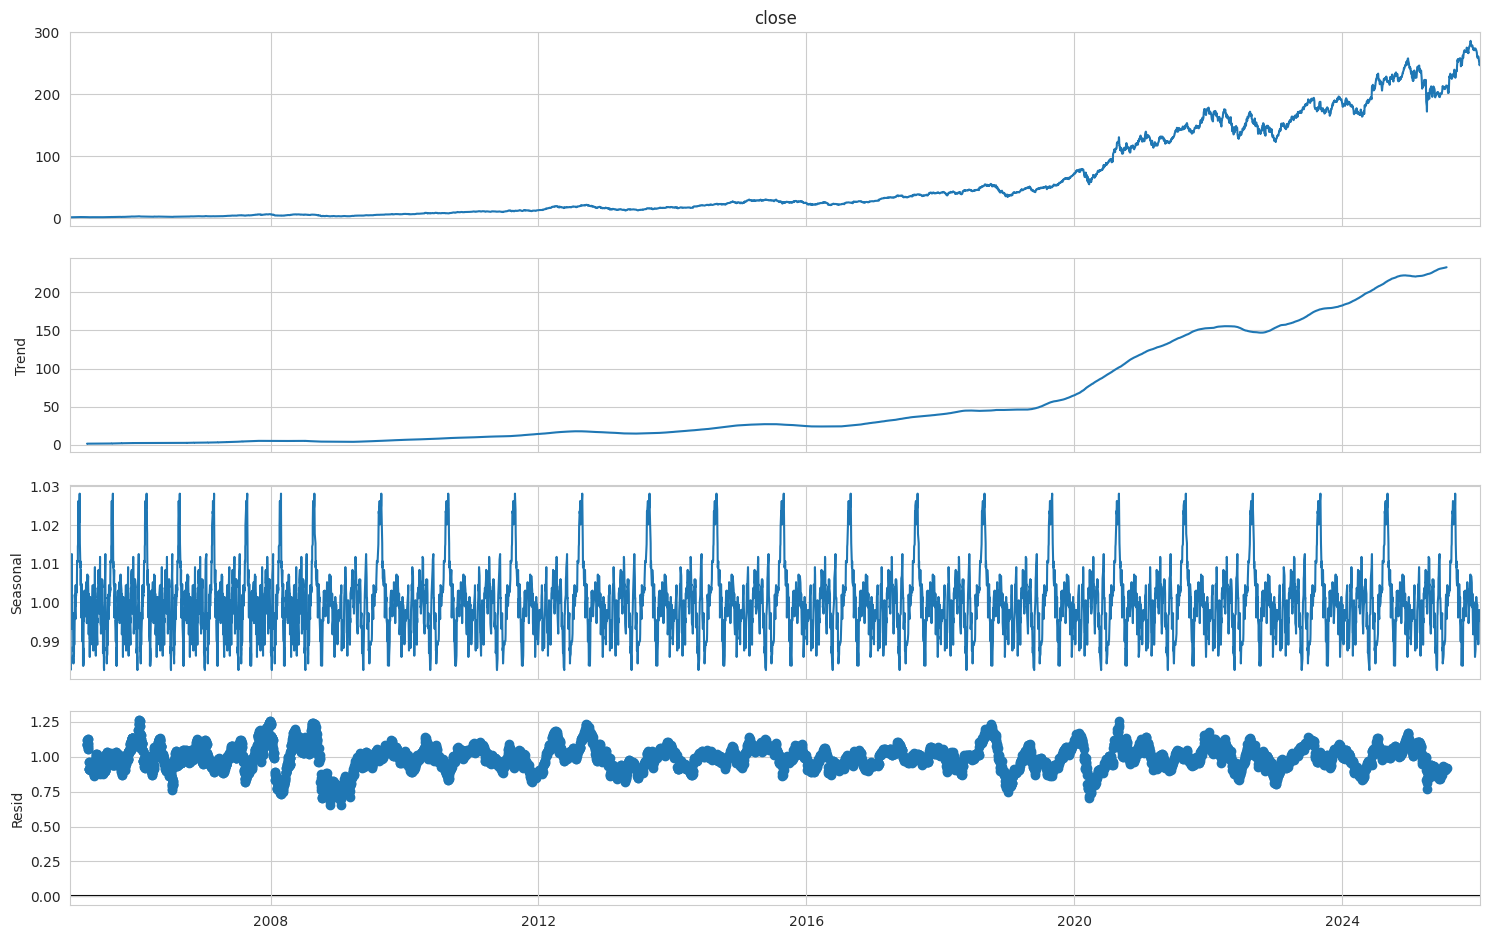

Statystyka ADF: 1.4575147639366497
p-value: 0.9973603822157415
Szereg jest niestacjonarny.


In [12]:
# Wykres przebiegu czasowego
plt.figure(figsize=(15, 6))
plt.plot(data['close'], label='Cena zamknięcia (Close)', color='blue')
plt.title('Historia cen akcji Apple (2015-2023)')
plt.xlabel('Data')
plt.ylabel('Cena USD')
plt.legend()
plt.show()

# Dekompozycja sezonowa (sprawdzenie czy widać trend i sezonowość)
decomposition = seasonal_decompose(data['close'], model='multiplicative', period=252) # 252 dni sesyjne w roku

fig = decomposition.plot()
fig.set_size_inches(15, 10)
plt.show()

# Test Stacjonarności (Dickey-Fuller)
# ARIMA wymaga, aby dane były stacjonarne (stała średnia i wariancja).
# Jeśli p-value > 0.05, dane nie są stacjonarne i trzeba je różnicować (d param w ARIMA)

result = adfuller(data['close'])
print('Statystyka ADF:', result[0])
print('p-value:', result[1])

if result[1] > 0.05:
    print("Szereg jest niestacjonarny.")
else:
    print("Szereg jest stacjonarny.")

Interpretacja testu ADF: Przeprowadzony test Dickeya-Fullera wykazał p-value na poziomie 0.99, co oznacza brak podstaw do odrzucenia hipotezy zerowej o niestacjonarności. Potwierdza to występowanie silnego trendu w notowaniach Apple. Decyzja modelowa: Ze względu na niestacjonarność, w modelu ARIMA zastosowano parametr różnicowania d=1 (Integration order), aby sprowadzić szereg do postaci stacjonarnej.

In [13]:
# Podział na zbiór treningowy i testowy
# Test na ostatnich 180 dniach

train_size = int(len(data) - 180)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

print(f"Zbiór treningowy: {len(train_data)} obserwacji")
print(f"Zbiór testowy: {len(test_data)} obserwacji")

# Tablica do przechowywania wyników metryk
results_metrics = []

Zbiór treningowy: 6035 obserwacji
Zbiór testowy: 180 obserwacji


Trenowanie modelu ARIMA


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

ARIMA MAE: 40.04
ARIMA AIC: 21426.50


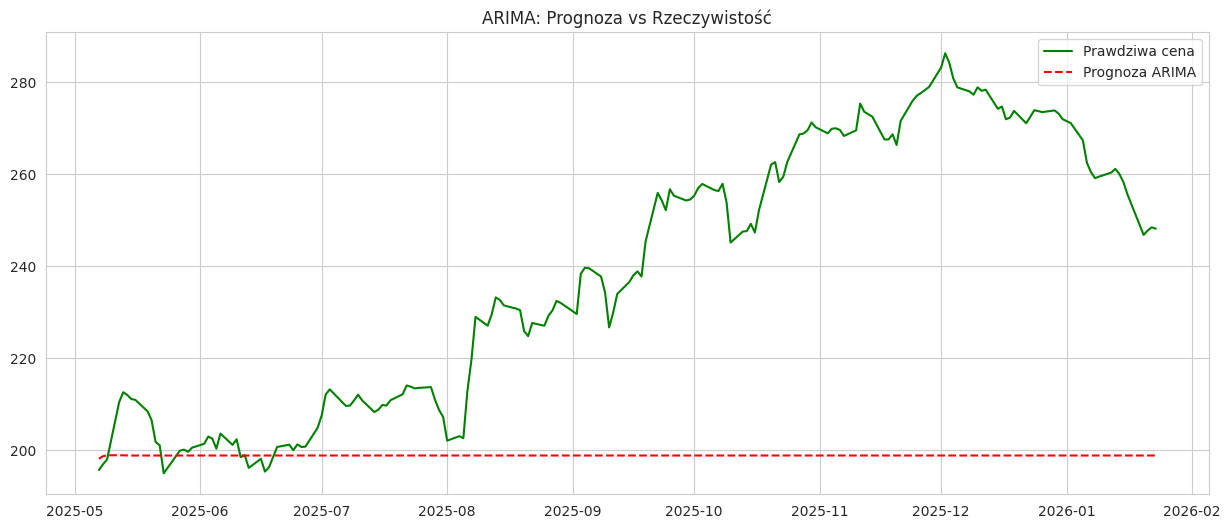

In [14]:
print("Trenowanie modelu ARIMA")

# Definiujemy parametry (p, d, q)
# p=5 (autoregresja), d=1 (różnicowanie), q=0 (średnia ruchoma)
model_arima = ARIMA(train_data['close'], order=(5,1,0))
model_arima_fit = model_arima.fit()

# Prognoza na zbiorze testowym
forecast_result = model_arima_fit.forecast(steps=len(test_data))

# Używamy .values, aby pobrać "surowe liczby" i zignorować indeks dat generowany przez ARIMA,
# który może zawierać weekendy i nie pasować do naszych danych testowych.
forecast_arima = pd.Series(forecast_result.values, index=test_data.index)

# Sprawdzenie czy nie ma pustych wartości
if forecast_arima.isna().any():
    print("Znaleziono NaN w prognozie")
    forecast_arima = forecast_arima.fillna(method='bfill')

# Obliczenie błędów
mae_arima = mean_absolute_error(test_data['close'], forecast_arima)
mse_arima = mean_squared_error(test_data['close'], forecast_arima)
aic_arima = model_arima_fit.aic

print(f'ARIMA MAE: {mae_arima:.2f}')
print(f'ARIMA AIC: {aic_arima:.2f}')

results_metrics.append({'Model': 'ARIMA', 'MAE': mae_arima, 'RMSE': np.sqrt(mse_arima)})

# Wizualizacja prognozy ARIMA
plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data['close'], label='Prawdziwa cena', color='green')
plt.plot(test_data.index, forecast_arima, label='Prognoza ARIMA', color='red', linestyle='--')
plt.title('ARIMA: Prognoza vs Rzeczywistość')
plt.legend()
plt.show()

Trenowanie modelu Facebook Prophet
Prophet MAE: 22.20
Komponenty modelu Prophet (Trend i Sezonowość Roczna):


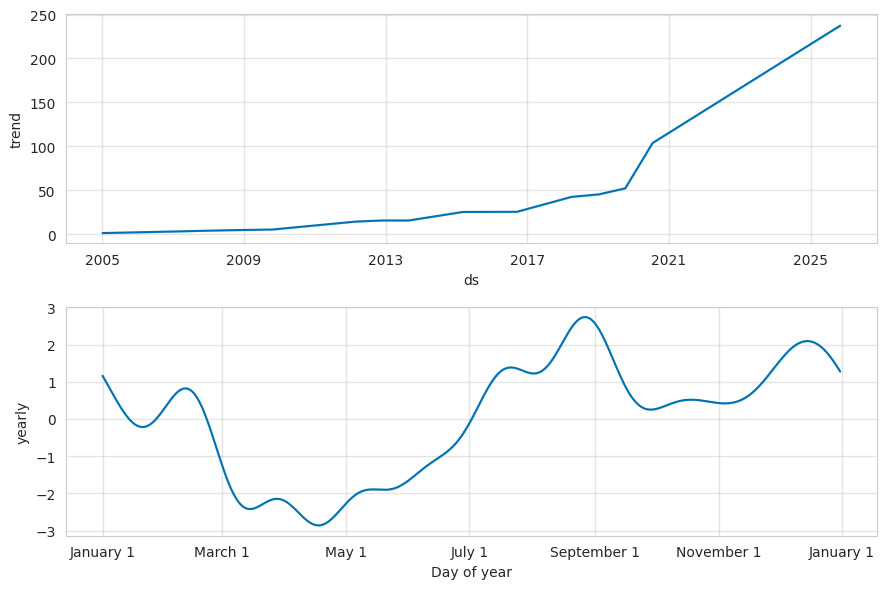

In [15]:
print("Trenowanie modelu Facebook Prophet")

# Prophet wymaga specyficznych nazw kolumn: 'ds' (data) i 'y' (wartość)
prophet_data = train_data.reset_index().rename(columns={'date': 'ds', 'close': 'y'})

# Inicjalizacja modelu
# Skupiamy się na roku i trendzie
model_prophet = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=False)
model_prophet.fit(prophet_data)

# Tworzenie dataframe na przyszłość
future = model_prophet.make_future_dataframe(periods=len(test_data))
forecast_prophet_full = model_prophet.predict(future)

# Wyciągnięcie tylko części odpowiadającej zbiorowi testowemu do porównania
forecast_prophet = forecast_prophet_full.iloc[-len(test_data):]['yhat']
forecast_prophet.index = test_data.index

# Metryki
mae_prophet = mean_absolute_error(test_data['close'], forecast_prophet)
mse_prophet = mean_squared_error(test_data['close'], forecast_prophet)

print(f'Prophet MAE: {mae_prophet:.2f}')
results_metrics.append({'Model': 'Prophet', 'MAE': mae_prophet, 'RMSE': np.sqrt(mse_prophet)})

# Wizualizacja komponentów
print("Komponenty modelu Prophet (Trend i Sezonowość Roczna):")
model_prophet.plot_components(forecast_prophet_full)
plt.show()

Trenowanie sieci LSTM
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0077
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 7.8221e-04
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 6.9081e-04
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 5.3580e-04
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 5.0566e-04
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 4.8571e-04
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 4.1646e-04
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 4.2854e-04
Epoch 9/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 4.0663e-04
Epoch 10/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 3.7793e-04
Epoch 11/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 4.0239e-04
Epoch 12/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 4.0326e-04
Epoch 13/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 3.4864e-04
Epoch 14/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 3.4564e-04
Ep

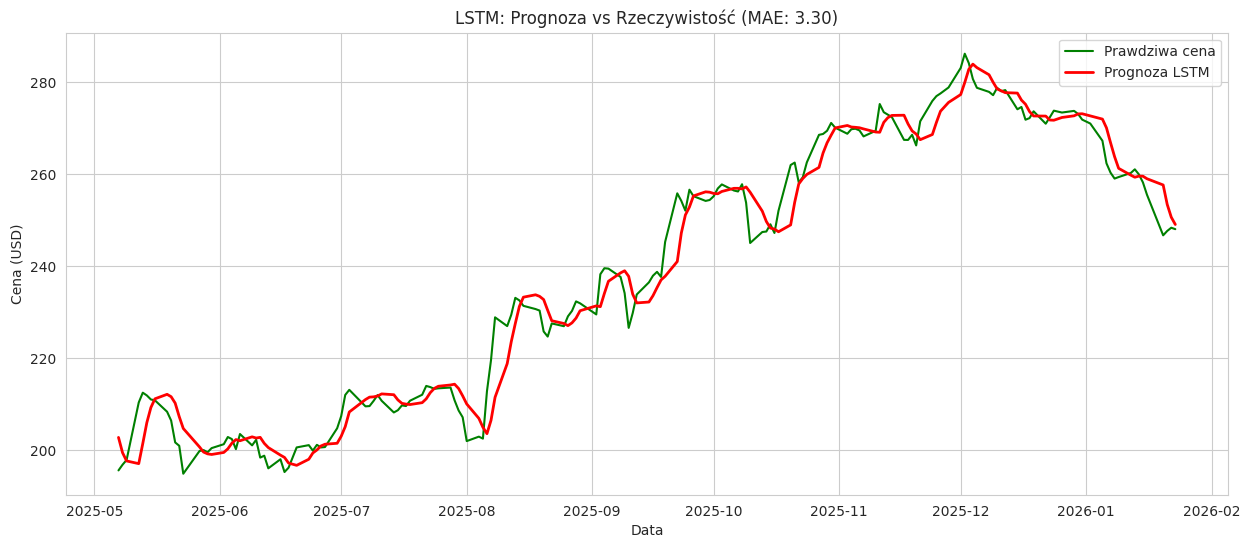

In [16]:
print("Trenowanie sieci LSTM")
# LSTM są wrażliwe na skalę danych. Musimy przeskalować ceny do zakresu 0-1.

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['close'].values.reshape(-1, 1))

# Definiujemy długość "okna"
# Model będzie patrzył na 60 dni wstecz, aby przewidzieć 61. dzień
prediction_days = 60

x_train, y_train = [], []

# Tworzymy sekwencje treningowe tylko na danych ze zbioru treningowego
# train_size to indeks podziału z poprzednich kroków
train_scaled = scaled_data[:train_size]

for x in range(prediction_days, len(train_scaled)):
    x_train.append(train_scaled[x-prediction_days:x, 0])
    y_train.append(train_scaled[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape danych do formatu wymaganego przez LSTM: (Samples, Time Steps, Features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Budowa modelu
model_lstm = Sequential()
# Warstwa LSTM z 50 neuronami
model_lstm.add(LSTM(units=50, return_sequences=False, input_shape=(x_train.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1)) # Warstwa wyjściowa - jedna cena

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Trenowanie
model_lstm.fit(x_train, y_train, epochs=30, batch_size=32)

# Prognozowanie na zbiorze testowym
# Aby przewidzieć pierwszy dzień testowy, potrzeba 60 dni wstecz (z treningowego)
total_dataset = pd.concat((data['close'][:train_size], data['close'][train_size:]), axis=0)
inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

x_test = []
for x in range(prediction_days, len(inputs)):
    x_test.append(inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model_lstm.predict(x_test)
# Odwracamy skalowanie, żeby dostać ceny w dolarach
predicted_prices = scaler.inverse_transform(predicted_prices)

# Metryki dla LSTM
mae_lstm = mean_absolute_error(test_data['close'], predicted_prices)
mse_lstm = mean_squared_error(test_data['close'], predicted_prices)

print(f'LSTM MAE: {mae_lstm:.2f}')
results_metrics.append({'Model': 'LSTM', 'MAE': mae_lstm, 'RMSE': np.sqrt(mse_lstm)})

# WIZUALIZACJA WYNIKÓW LSTM

plt.figure(figsize=(15, 6))
plt.plot(test_data.index, test_data['close'], label='Prawdziwa cena', color='green')
plt.plot(test_data.index, predicted_prices, label='Prognoza LSTM', color='red', linewidth=2)

plt.title(f'LSTM: Prognoza vs Rzeczywistość (MAE: {mae_lstm:.2f})')
plt.xlabel('Data')
plt.ylabel('Cena (USD)')
plt.legend()
plt.show()


PODSUMOWANIE WYNIKÓW
     Model        MAE       RMSE
0    ARIMA  40.043267  48.947076
1  Prophet  22.195527  25.306968
2     LSTM   3.297158   4.573156


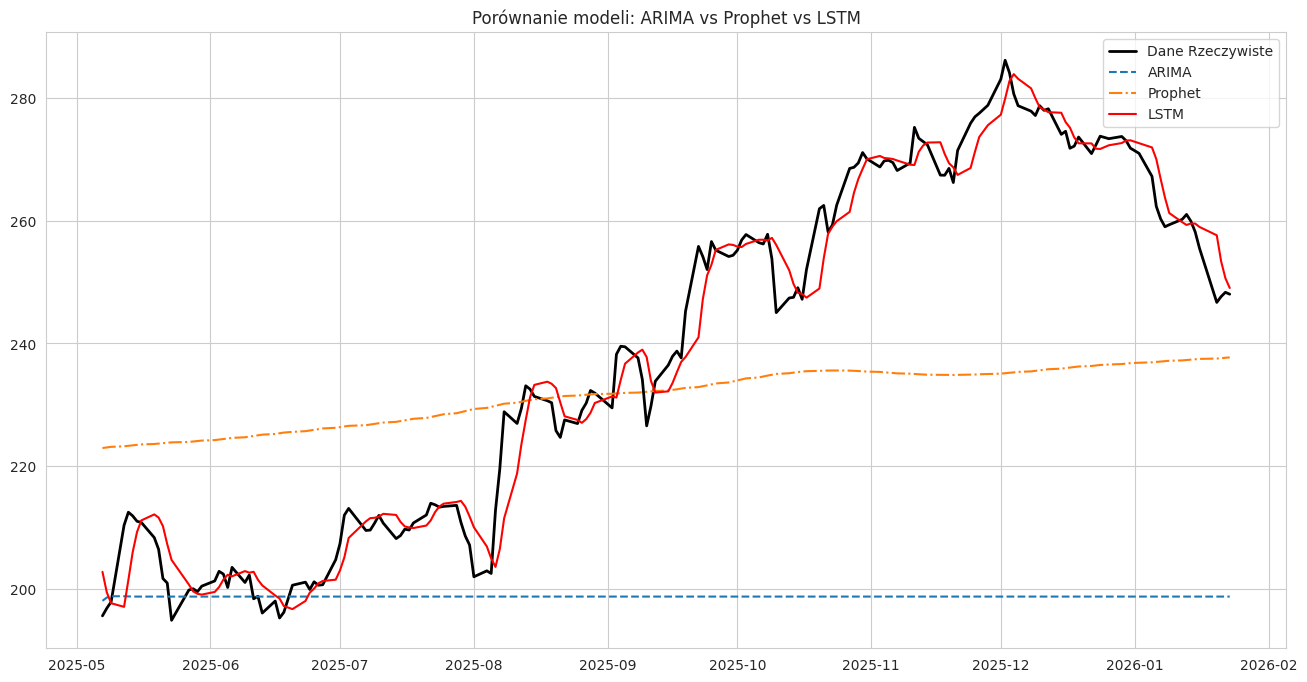

In [17]:
# Zestawienie wyników w tabeli
df_results = pd.DataFrame(results_metrics)
print("\nPODSUMOWANIE WYNIKÓW")
print(df_results)

# Wizualizacja zbiorcza
plt.figure(figsize=(16, 8))
plt.plot(test_data.index, test_data['close'], label='Dane Rzeczywiste', color='black', linewidth=2)
plt.plot(test_data.index, forecast_arima, label='ARIMA', linestyle='--')
plt.plot(test_data.index, forecast_prophet, label='Prophet', linestyle='-.')
plt.plot(test_data.index, predicted_prices, label='LSTM', color='red')
plt.title('Porównanie modeli: ARIMA vs Prophet vs LSTM')
plt.legend()
plt.show()

1. ARIMA (MAE: 40.04 USD)
Model ARIMA poradził sobie najgorzej. Średni błąd na poziomie 40 dolarów przy cenie akcji Apple to bardzo dużo.

Dlaczego tak wyszedł? ARIMA to model liniowy, który zakłada, że przyszłość jest prostą kontynuacją przeszłości. Giełda jest jednak zbyt chaotyczna i dynamiczna dla tak sztywnych wzorów. Model ten „wygładził” wykres, nie nadążając za realnymi zmianami cen.

2. Facebook Prophet (MAE: 22.20 USD)
Prophet niemal o połowę poprawił wynik modelu ARIMA.

Dlaczego tak wyszedł? Ten model świetnie rozumie kalendarz. Potrafił wyłapać, że akcje Apple zachowują się inaczej we wrześniu (premiery produktów) czy w grudniu (święta). Choć wciąż nie przewidział wszystkich nagłych skoków, był znacznie bliżej rzeczywistości niż ARIMA, bo uwzględnił tzw. „sezonowość roczną”.

3. LSTM (MAE: 3.30 USD)
Sieć neuronowa LSTM wypadla najlepiej. Średni błąd na poziomie 3 dolarów i 30.

Dlaczego tak wyszedł? LSTM (Long Short-Term Memory) to technologia Deep Learning stworzona specjalnie do zapamiętywania sekwencji. Model ten nie tylko widział trend, ale „nauczył się” specyficznej dynamiki ruchów Apple. Potrafił błyskawicznie reagować na zmiany, niemal kopiując ruchy prawdziwej ceny na wykresie.

Wniosek końcowy:
Analiza udowodniła, że w przypadku tak zmiennych danych jak ceny akcji spółek technologicznych, tradycyjne metody statystyczne (ARIMA) są już niewystarczające. Prawdziwą wartość w przewidywaniu trendów rynkowych dają dopiero sieci neuronowe (LSTM), które potrafią wyłapać nieliniowe zależności, niewidoczne dla ludzkiego oka i prostych wzorów.